In [5]:
%autosave 2
%load_ext autoreload
%autoreload 2
%matplotlib inline

Autosaving every 2 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analíse de reviews de videogames da Amazon

## Referencias
- [NLTK Book Online](http://www.nltk.org/book/)

* __Turing Talks__
    - [Introdução a NLTK com Dom Casmurro](https://medium.com/turing-talks/uma-an%C3%A1lise-de-dom-casmurro-com-nltk-343d72dd47a7)
    - [Introdução ao Processamento de Linguagem Natural com Baco Exu do Blues
](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-ao-processamento-de-linguagem-natural-com-baco-exu-do-blues-17cbb7404258)
    - [Introdução a Bag of Words e TF-IDF](https://medium.com/turing-talks/introdu%C3%A7%C3%A3o-a-bag-of-words-e-tf-idf-43a128151ce9)
        - [notebook](https://github.com/turing-usp/BoW-e-TFIDF/blob/master/BoW_e_TFIDF.ipynb)
    - [Sua primeira análise de sentimentos com scikit-learn](https://medium.com/turing-talks/sua-primeira-an%C3%A1lise-de-sentimentos-com-scikit-learn-a47c088ea7bd)
        - [modelos](https://www.kaggle.com/camillafonseca/nlp-an-lise-de-sentimento-do-olist-para-iniciantes#Modelos)
    - [Como Avaliar Seu Modelo de Classificação](https://medium.com/turing-talks/como-avaliar-seu-modelo-de-classifica%C3%A7%C3%A3o-acd2a03690e)

In [6]:
from rich import print # print ficar bonitinho

In [7]:
import pandas as pd
import numpy as np

In [8]:
#import nltk
from nltk.corpus import stopwords # remover stopwords
from nltk import WordNetLemmatizer
import string, re # remover pontucao
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
#nltk.download()

In [10]:
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

In [11]:
plt.style.use('seaborn')

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : '16'}

mpl.rc('font', **font)

In [12]:
from wordcloud import WordCloud
from PIL import Image # Pra mascara do wordcloud

In [13]:
dfReview = pd.read_csv('video_games_reviews_test.csv')
dfReviewTrain = pd.read_csv('video_games_reviews_train.csv')
dfReviewValid = pd.read_csv('video_games_reviews_dev.csv')

In [14]:
dfReviewTrain

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,9604,222941,A1U1AK7HKB2BLN,B00CX6XKK6,jayfer,"[4, 51]",ive got to play this on both consoles now and ...,1,wasted 500 dollars on the xbox one.,1385078400,"11 22, 2013"
1,5428,106670,A1L1D50VH2AX7J,B0017UFWMS,Anjoyla,"[0, 0]",This game gives you a series of word puzzles t...,2,Margots Word Brain,1321833600,"11 21, 2011"
2,198,24455,A2JWU211CM0BYE,B00005RCR0,DCN2049,"[0, 1]",You should pretty much already know what this ...,4,"Excellent product, watch the discs",1360540800,"02 11, 2013"
3,6070,42574,A1DP3YZ2OQWAP4,B0000ARQMW,liz,"[0, 0]",I really like this game i love all the challen...,5,Jammin banging game,1383436800,"11 3, 2013"
4,11616,172598,A48Z207T98FN0,B004HYK8Y8,The Reverend,"[296, 368]",*** please read the 12/9/11 update below this ...,1,Consumers are NOT Beta-Testers !!! (updated),1322784000,"12 2, 2011"
...,...,...,...,...,...,...,...,...,...,...,...
7995,3409,162881,A24QLA72AQUUP9,B003VAM392,collin,"[0, 0]",Arrived in mail promptly. Working great so fa...,3,Scrolling,1341273600,"07 3, 2012"
7996,2031,145725,A33JECQ09K2BVE,B002Q21X7Y,"NYCGreg ""Snarky Tech Guy""","[6, 15]","This game is a perfect example of ""style over ...",2,Style over substance,1287532800,"10 20, 2010"
7997,1193,28770,ASLQ16GQ9X8CS,B000066TS7,Alan,"[6, 6]",Let me tell you from the start: I'm not a big ...,5,Exceeds Expectations,1067385600,"10 29, 2003"
7998,9305,194209,A1BONAS0DQEZMY,B005VKRGXI,Laughart,"[0, 0]",For $24.00 new this game delivers! I bought th...,5,$23.99 - Good Deal!,1377475200,"08 26, 2013"


* reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* asin - ID of the product, e.g. 0000013714
* reviewerName - name of the reviewer
* helpful - helpfulness rating of the review, e.g. 2/3
* reviewText - text of the review
* overall - rating of the product
* summary - summary of the review
* unixReviewTime - time of the review (unix time)
* reviewTime - time of the review (raw)

[source](https://jmcauley.ucsd.edu/data/amazon/)

## Pré-processamento e Análise do corpus


* [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
    * [Sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix)
* [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)
* [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [10]:
dfReview.head(10)

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,12154,25980,A16416X67B4ZKJ,B00005V6BB,"""mcfly70""","[1, 1]","MOH was good and all, but when you reach the c...",4,MOH: THE ACTUAL WAR WAS BETTER THE 3RD MCFLY R...,1035158400,"10 21, 2002"
1,7333,215010,A2Q2ADX9C9I5WZ,B00AZWE7ES,MCRC,"[0, 4]",I am so glad I only paid $15 for this game dur...,2,15 fps? really?,1399334400,"05 6, 2014"
2,6703,188851,A30IXQWBRD3GU9,B0053BCO00,Jerry,"[0, 0]",Forget this mario kart get mario kart ds or th...,3,ehhhh,1373414400,"07 10, 2013"
3,5649,93541,A1S7NYZF69KYAP,B000VRCNLG,Peanut Pedro,"[0, 1]",When I purchased this game from Amazon I certa...,1,Defective Disk/Great Seller,1348963200,"09 30, 2012"
4,2955,24169,A2MPAOYEC1KWEI,B00005R5PO,Mali,"[0, 0]",I love platform games but not many are out the...,4,It's not Spyro...,1073260800,"01 5, 2004"
5,365,19671,ACUYXGCMWVF7S,B00005MO5E,Matthieu P. Raillard,"[7, 11]","Madden 2002 is an improvement over 2001, for s...",3,"Solid, with one FATAL flaw...",999129600,"08 30, 2001"
6,5078,153185,A28TPVUQ4WKKLU,B003GT8IL0,Brotherhood1994x,"[0, 0]",This game is a huge step up for Warner Bros. T...,4,I love the F.E.A.R. games,1351641600,"10 31, 2012"
7,1310,114822,A2HKGZ1QKK9TU0,B001F0OOF6,"Spirited Treasure ""Spirit""","[1, 2]",This game is horribly glitchy. Even though the...,1,don't waste your money,1229731200,"12 20, 2008"
8,4251,52562,A1UPNUCA5ATMPP,B0006TO2HM,David Keyworth,"[7, 15]",Is Apollo Justice a true Ace Attorney game? Ye...,3,To all fans of Phoenix Wright: I'm very sorry.,1221350400,"09 14, 2008"
9,23,80948,A1KBV71PGFFPVV,B000N60GPK,"D. Bowman ""Tech Dork""","[5, 6]",There is already a lot said in the other revie...,4,Play at the same time with your kids (two-play...,1214611200,"06 28, 2008"


In [11]:
dfReview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   level_0         2500 non-null   int64 
 1   index           2500 non-null   int64 
 2   reviewerID      2500 non-null   object
 3   asin            2500 non-null   object
 4   reviewerName    2471 non-null   object
 5   helpful         2500 non-null   object
 6   reviewText      2499 non-null   object
 7   overall         2500 non-null   int64 
 8   summary         2500 non-null   object
 9   unixReviewTime  2500 non-null   int64 
 10  reviewTime      2500 non-null   object
dtypes: int64(4), object(7)
memory usage: 215.0+ KB


In [12]:
# remover valores NaN do texto
dfReview.dropna(axis=0, subset=['reviewText'], inplace=True)

### Remocao de stopwords e pontuacao

In [13]:
def tratamento_basico(texto,
                      pontuacao = re.compile('|'.join(map(re.escape, string.punctuation))),
                      stpwrds = stopwords.words('english')):
    """tratamento basico do texto com remocao de pontucao e e stopwords
    
    input:
         - texto: (str) -> menssagem a ser processada
         - pontuacao (re.Pattern) -> caracteres de pontuacao a serem removidos
                                     compilados em uma regex
                                     default: providos pelo string.punctuation
                                              usando o re.compile('|'.join(map(re.escape, string.punctuation)))
         - stpwrds (list)  -> lista de stopwords
                              default: providos pela funcao stopwords.words('english') da lib nltk.corpus
    output:
         (str) ->  menssagem pre-processada em caixa baixa
    """
    # para pontucao so usar o metodo sub da regex de entrada
    texto = pontuacao.sub("", texto)
    
    # para as stopwords fazer por compreensao de lista, juntando chars em
    # palavras para nao remover as sopwords que estejam dentro de uma outra palavra
    # e usar os texto em caixa baixa para dar match
    texto = [palavra.lower() for palavra in texto.lower().split() if palavra not in stpwrds]
    
    return texto

In [14]:
print('[bold red]antes do tratamento_basico():[/bold red]')
print()
dfReview['reviewText'].head(10)

antes do tratamento_basico():

0    MOH was good and all, but when you reach the c...
1    I am so glad I only paid $15 for this game dur...
2    Forget this mario kart get mario kart ds or th...
3    When I purchased this game from Amazon I certa...
4    I love platform games but not many are out the...
5    Madden 2002 is an improvement over 2001, for s...
6    This game is a huge step up for Warner Bros. T...
7    This game is horribly glitchy. Even though the...
8    Is Apollo Justice a true Ace Attorney game? Ye...
9    There is already a lot said in the other revie...
Name: reviewText, dtype: object

In [15]:
print('[bold red]depois do tratamento_basico():[/bold red]')
print()
dfReview['reviewText_prep'] = dfReview['reviewText'].apply(lambda x:' '.join(tratamento_basico(x)))
dfReview['reviewText_prep'].head(10)

depois do tratamento_basico():

0    moh good reach couple last levels therell noth...
1    glad paid 15 game sonys golden week saleit tec...
2    forget mario kart get mario kart ds one wii wa...
3    purchased game amazon certainly looked forward...
4    love platform games many tried crash bandicoot...
5    madden 2002 improvement 2001 sure exactly bran...
6    game huge step warner bros graphics mechanics ...
7    game horribly glitchy even though company sell...
8    apollo justice true ace attorney game yesis wo...
9    already lot said reviews thought would solely ...
Name: reviewText_prep, dtype: object

In [16]:
dfReview['len_review_chars'] = dfReview['reviewText_prep'].apply(lambda x:len(x))
dfReview['len_review_words'] = dfReview['reviewText_prep'].apply(lambda x:len([palavra for palavra in x.split()]))

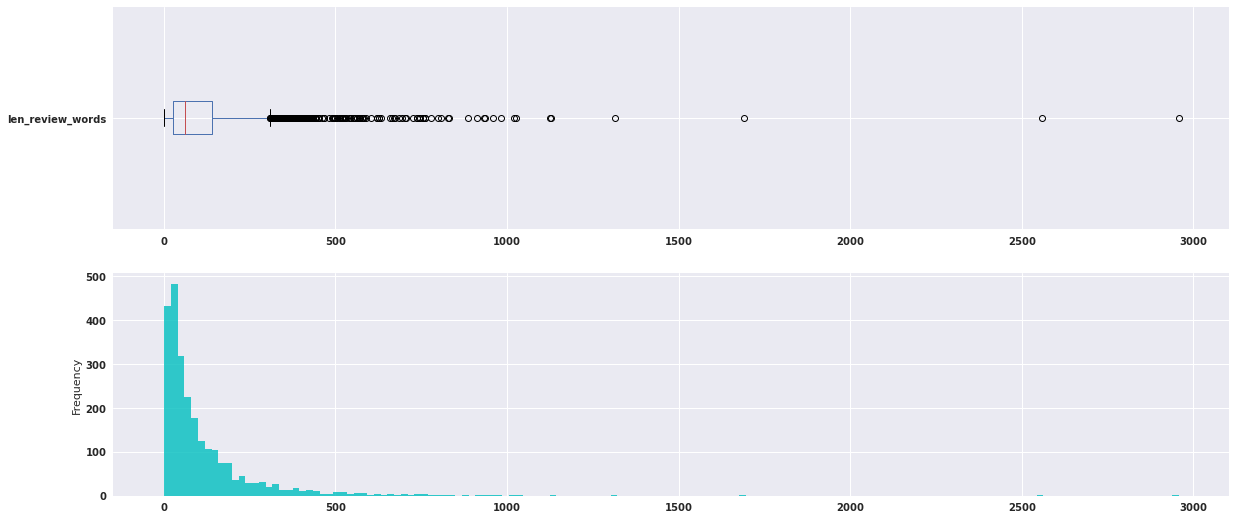

In [33]:
plt.figure(figsize=(20,9))
gs = gridspec.GridSpec(2, 1)

ax0 = plt.subplot(gs[0:1])
ax1 = plt.subplot(gs[1:])

p = dfReview['len_review_words'].plot(kind='box', ax=ax0, vert=False, )
p = dfReview['len_review_words'].plot(kind='hist', bins=150, ax=ax1, alpha=.8, color='c', label='words')

In [18]:
#  maior numero de caracteres
dfReview[dfReview['len_review_words'] == dfReview['len_review_words'].max()]['reviewText'].iloc[0]

'This is the same review as the one I posted for the standard edition of the game. I will however add that with the Collector\'s Edition, one of the biggest benefits you receive is the new Prothean character that is really awesome, and it would cost 10 dollars to buy the DLC without buying the CE. Other extras in this edition include essentially useless in-game weapons and a robo-dog that just walks around in the Cargo Bay. You do however get a cool little art book, a mini comic book, an N7 patch, a post card, and a cool steel case with the special edition. I figure this is worth much more than the extra 20 dollar price increase from the standard edition. Now onto the review of the game:For those that haven\'t finished Mass Effect 3, the first part of my review will be spoiler free, but the second part must be rife with spoilers because the story and ending is the biggest problem of the game. I\'ll also preface this review by saying that the ME series had been probably my favorite gami

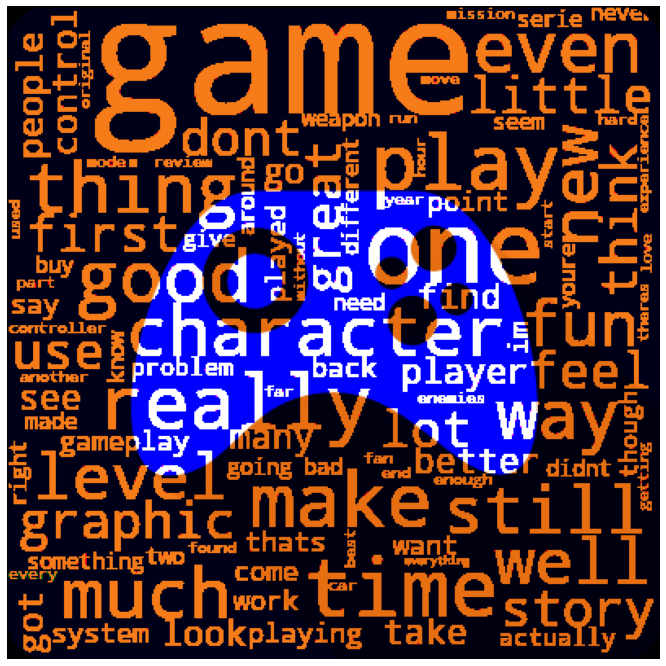

In [19]:
# fiz baseado no codigo: https://www.kaggle.com/subinium/simple-trick-image-word-cloud-masking/comments
# fonte da img: https://www.pngkey.com/png/full/207-2078078_game-controller-icon-png-illustration.png

img = np.array(Image.open("./controller.jpeg"))
img_matrix = np.array(img)


text = ' '.join(list(dfReview['reviewText_prep']))
wc = WordCloud(background_color="yellow", max_words=100 , max_font_size=100, width=img_matrix.shape[0], height=img_matrix.shape[1], random_state=42)
wc.generate(text)
txt_matrix = wc.to_array()

#print(img_matrix.shape, txt_matrix.shape)

img_matrix[txt_matrix == 255] = 0
#print(img_matrix.shape)

plt.figure(figsize=(12,12))
plt.imshow(img_matrix)
x = plt.axis('off')

In [20]:
dfReview

,level_0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewText_prep,len_review_chars,len_review_words
0,12154,25980,A16416X67B4ZKJ,B00005V6BB,"""mcfly70""","[1, 1]","MOH was good and all, but when you reach the c...",4,MOH: THE ACTUAL WAR WAS BETTER THE 3RD MCFLY R...,1035158400,"10 21, 2002",moh good reach couple last levels therell noth...,527,79
1,7333,215010,A2Q2ADX9C9I5WZ,B00AZWE7ES,MCRC,"[0, 4]",I am so glad I only paid $15 for this game dur...,2,15 fps? really?,1399334400,"05 6, 2014",glad paid 15 game sonys golden week saleit tec...,350,53
2,6703,188851,A30IXQWBRD3GU9,B0053BCO00,Jerry,"[0, 0]",Forget this mario kart get mario kart ds or th...,3,ehhhh,1373414400,"07 10, 2013",forget mario kart get mario kart ds one wii wa...,82,15
3,5649,93541,A1S7NYZF69KYAP,B000VRCNLG,Peanut Pedro,"[0, 1]",When I purchased this game from Amazon I certa...,1,Defective Disk/Great Seller,1348963200,"09 30, 2012",purchased game amazon certainly looked forward...,392,57
4,2955,24169,A2MPAOYEC1KWEI,B00005R5PO,Mali,"[0, 0]",I love platform games but not many are out the...,4,It's not Spyro...,1073260800,"01 5, 2004",love platform games many tried crash bandicoot...,429,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3869,171000,A1HDZE291YUBO5,B004FSE52C,John Kimble,"[5, 12]",Too much quicktime nonsense. Too many cutscen...,1,sucks,1382832000,"10 27, 2013",much quicktime nonsense many cutscenes holds h...,96,14
2496,4549,63792,A2FOZVHA7922QG,B000BNKSVC,mark twain,"[2, 7]",it's really a superficial game lacking any rea...,2,quickly gets old...,1142640000,"03 18, 2006",really superficial game lacking real depth lik...,172,27
2497,5705,67626,A153SJSPFMO0AW,B000FIVC2W,"gee ""beachboy""","[0, 1]",I wanna say this is the best game on PS2 for a...,5,a MUST PLAY,1285113600,"09 22, 2010",wanna say best game ps2 adults battle system l...,245,39
2498,5566,51090,A2HONG3KI05QIX,B0002XL3BA,Jeremy K. Jones,"[2, 4]",This is one of the most fun video games I've p...,5,"A whole lot of fun, for adults only",1113177600,"04 11, 2005",one fun video games ive played long time game ...,277,42


<AxesSubplot:xlabel='overall', ylabel='len_review_words'>

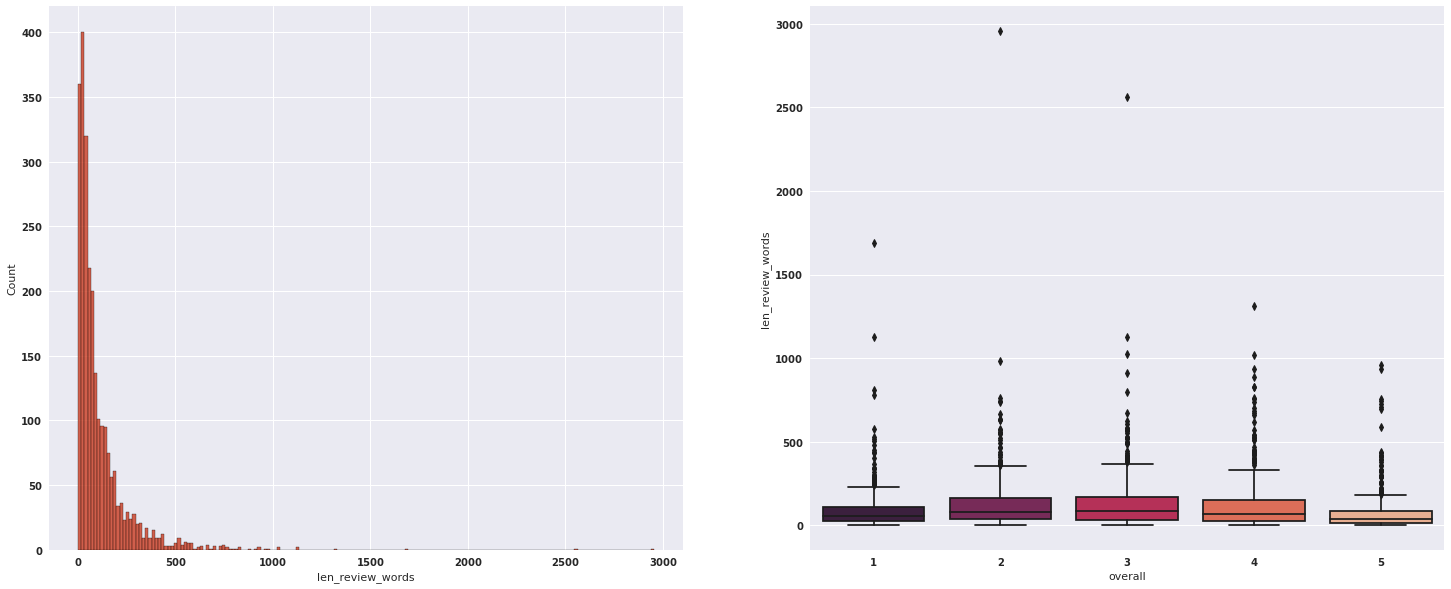

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(25,10))
sns.histplot(data=dfReview, x='len_review_words', kde=False, ax=ax[0], color='#c83014')
sns.boxplot(data=dfReview, x='overall', y='len_review_words', palette='rocket', ax=ax[1])

### Stemizacao

In [23]:
msgVector = CountVectorizer(analyzer=tratamento_basico).fit(dfReview['reviewText'])

In [24]:
len(msgVector.vocabulary_)

29051